In [24]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [61]:
euro = pd.read_csv('./data/eurovision/cleaned_data.csv')
mino = pd.read_csv("./data/minorities/_eurostat_cleared_data.csv")
popu = pd.read_csv("./data/minorities/_population_data.csv")

## Istotne mniejszości narodowe

In [62]:
sig_matrix = mino.merge(popu, left_on="citizen_name", right_on="country")
sig_matrix

,citizen_name,minority_name,head_count,country,population
0,Albania,Austria,6592.0,Albania,3107100
1,Albania,Belgium,3176.0,Albania,3107100
2,Albania,Bulgaria,564.0,Albania,3107100
3,Albania,Cyprus,388.0,Albania,3107100
4,Albania,Czech Republic,688.0,Albania,3107100
...,...,...,...,...,...
1268,United Kingdom,Slovenia,250.0,United Kingdom,68459055
1269,United Kingdom,Spain,379448.0,United Kingdom,68459055
1270,United Kingdom,Sweden,52248.0,United Kingdom,68459055
1271,United Kingdom,Switzerland,89412.0,United Kingdom,68459055


In [63]:
len(sig_matrix.dropna()) == len(sig_matrix)

True

In [64]:
sig_matrix['percent_pop'] = (sig_matrix['head_count'] / sig_matrix['population']) * 100
sig_matrix.head()

,citizen_name,minority_name,head_count,country,population,percent_pop
0,Albania,Austria,6592.0,Albania,3107100,0.212159
1,Albania,Belgium,3176.0,Albania,3107100,0.102218
2,Albania,Bulgaria,564.0,Albania,3107100,0.018152
3,Albania,Cyprus,388.0,Albania,3107100,0.012488
4,Albania,Czech Republic,688.0,Albania,3107100,0.022143


### Treshhold signinficance

In [65]:
THRESHOLD_CUT = 90 # only top 10% edges are counted as significant

In [66]:
threshold = np.percentile(sig_matrix["percent_pop"], THRESHOLD_CUT)

In [67]:
sig_matrix['significant_threshold'] = sig_matrix['percent_pop'] > threshold

In [68]:
sig_matrix.head()

,citizen_name,minority_name,head_count,country,population,percent_pop,significant_threshold
0,Albania,Austria,6592.0,Albania,3107100,0.212159,False
1,Albania,Belgium,3176.0,Albania,3107100,0.102218,False
2,Albania,Bulgaria,564.0,Albania,3107100,0.018152,False
3,Albania,Cyprus,388.0,Albania,3107100,0.012488,False
4,Albania,Czech Republic,688.0,Albania,3107100,0.022143,False


### Z-score significance

In [69]:
Z_THRESHOLD = 1.5 # cca 0.933

In [70]:
mean_weight = sig_matrix["percent_pop"].mean()
std_dev_weight = sig_matrix["percent_pop"].std()
sig_matrix["z_score"] = (sig_matrix["percent_pop"] - mean_weight) / std_dev_weight

In [71]:
sig_matrix['significant_zscore'] = sig_matrix['percent_pop'] > Z_THRESHOLD

In [72]:
sig_matrix.head()

,citizen_name,minority_name,head_count,country,population,percent_pop,significant_threshold,z_score,significant_zscore
0,Albania,Austria,6592.0,Albania,3107100,0.212159,False,-0.038115,False
1,Albania,Belgium,3176.0,Albania,3107100,0.102218,False,-0.091661,False
2,Albania,Bulgaria,564.0,Albania,3107100,0.018152,False,-0.132604,False
3,Albania,Cyprus,388.0,Albania,3107100,0.012488,False,-0.135363,False
4,Albania,Czech Republic,688.0,Albania,3107100,0.022143,False,-0.130660,False


### Visualization

In [73]:
def vizualize(df):
    G = nx.DiGraph()
    for _, row in df.iterrows():
        G.add_edge(row["citizen_name"], row["minority_name"], weight=row["percent_pop"])
    pos = nx.spring_layout(G, seed=1001)
    # edge_labels = nx.get_edge_attributes(G, 'weight')
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=15)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title("Network of European Countries by Minority Percentage")
    plt.axis("off")
    plt.show()

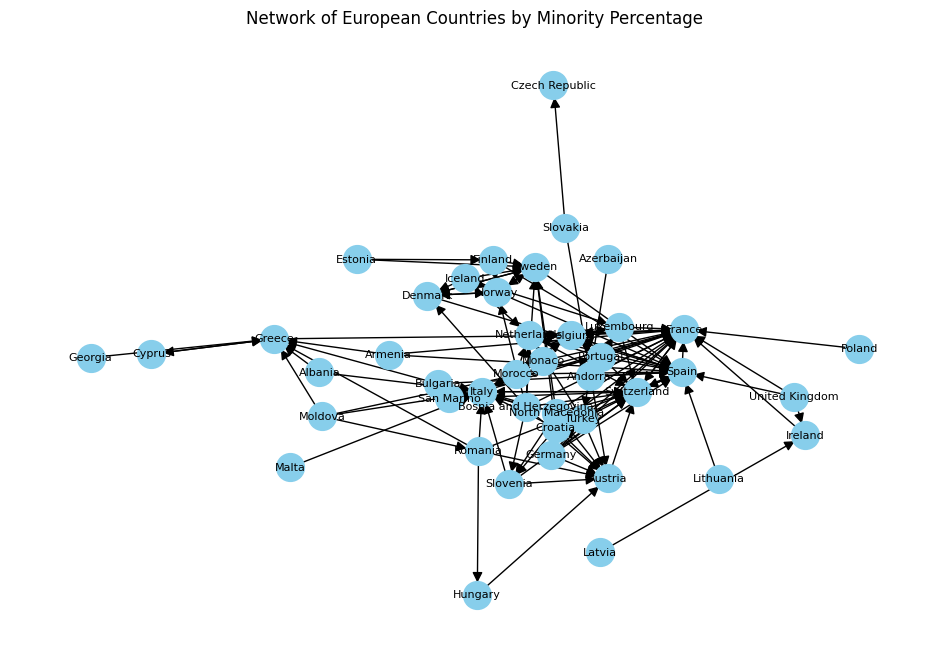

In [74]:
vizualize(sig_matrix[sig_matrix['significant_threshold']])

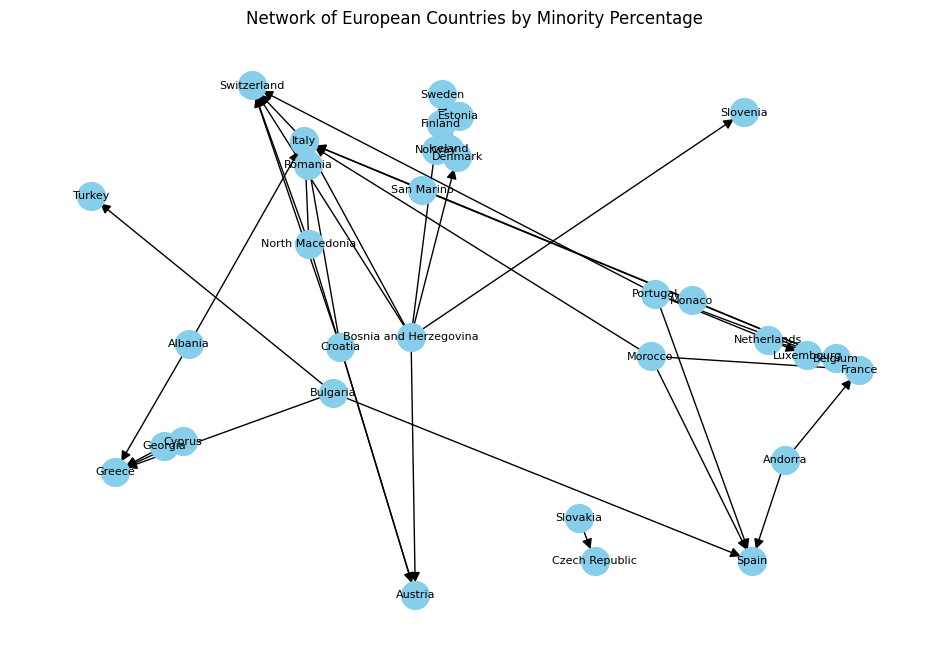

In [75]:
vizualize(sig_matrix[sig_matrix['significant_zscore']])